# DeepFakeShield | ViT + Attention Rollout for Fake Face Detection

##  Problem Statement:
With the rise of AI-generated DeepFake media, detecting manipulated facial images has become crucial to prevent misinformation, identity fraud, and digital impersonation. This project aims to classify facial images as real or fake using a Vision Transformer (ViT) model, and interpret the model’s decisions using transformer-specific attention rollout (instead of traditional Grad-CAM).

---

## Objective:
- Load and explore the “Real and Fake Face Detection” dataset.

- Preprocess images with strong data augmentation and normalization.

- Handle class imbalance using computed class weights.

- Build and train a Vision Transformer (ViT) model for binary classification.

- Implement early stopping and save the best performing model.

- Evaluate using accuracy, confusion matrix, classification report.

- Visualize ViT attention maps (attention rollout) to explain why an image was classified as fake.

---

##  Tools & Libraries:
- Modeling: PyTorch, Torchvision, Timm (ViT)

- Visualization: Matplotlib, OpenCV, PIL

- Evaluation: Scikit-learn (classification metrics)

- Explainability: Attention Rollout for Vision Transformers


In [1]:
# ========== Core Python Libraries ==========
import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# ========== Torch and Deep Learning ==========
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ========== Vision Models and Transforms ==========
import timm
from torchvision import transforms

# ========== Evaluation Metrics ==========
from sklearn.metrics import classification_report, confusion_matrix

# ========== Utility ==========
from einops import rearrange

# ========== Environment Setup ==========
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# load datasets
REAL_DIR = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real"
FAKE_DIR = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake"

real_images = os.listdir(REAL_DIR)
fake_images = os.listdir(FAKE_DIR)

In [3]:
print(f"total Real images are {len(real_images)}")
print(f"total fake images are {len(fake_images)}")

total Real images are 1081
total fake images are 960


## **Lets check the Sample of Real and Fake images**

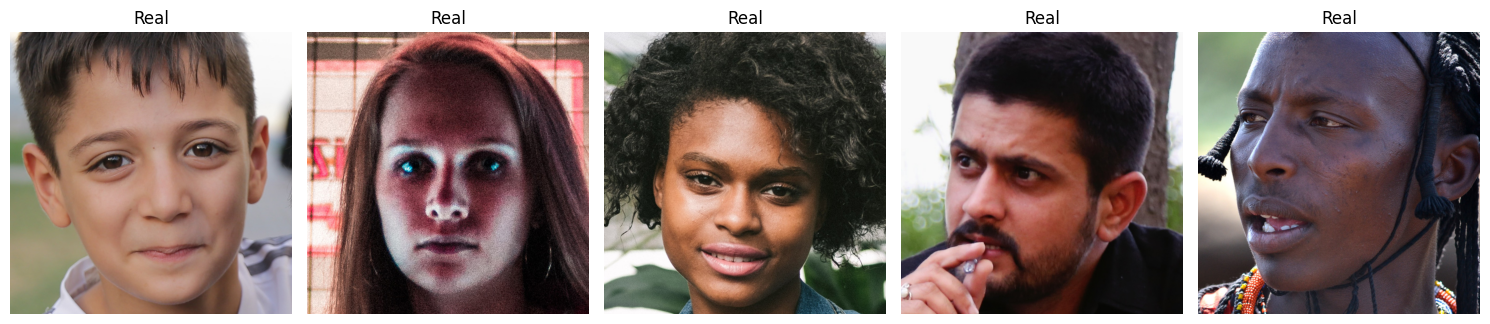

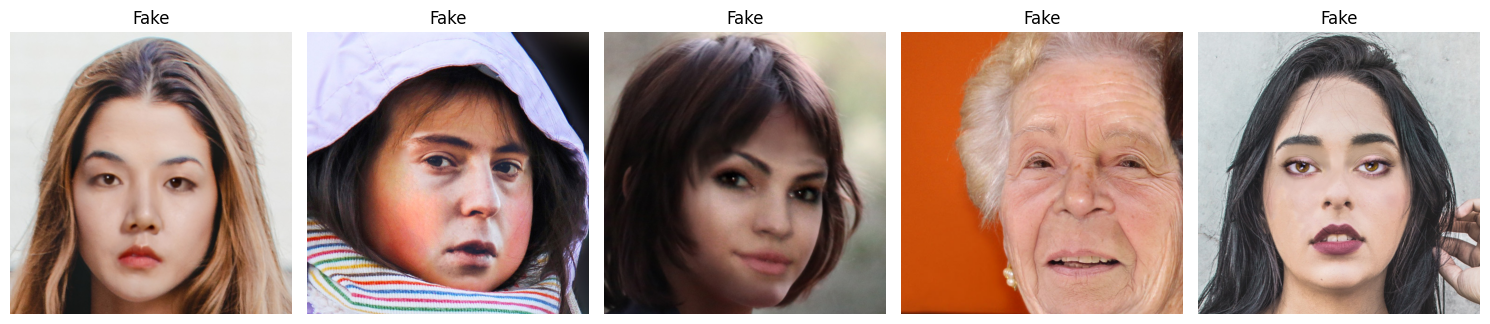

In [4]:
def show_samples(path, label="Real", n=5):
    images = random.sample(os.listdir(path), n)
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i, img_file in enumerate(images):
        img = Image.open(os.path.join(path, img_file))
        ax[i].imshow(img)
        ax[i].set_title(f"{label}")
        ax[i].axis("off")
    plt.tight_layout()
    plt.show()

show_samples(REAL_DIR, label="Real")
show_samples(FAKE_DIR, label="Fake")


**Lets check Image size (width and height)**

In [5]:
def image_size(folder,label):
    size = []
    for f in os.listdir(folder):
        with Image.open(os.path.join(folder,f)) as img:
            size.append(img.size) #W&H
    df = pd.DataFrame(size,columns=['width','height'])
    df['label'] = label
    return df

df_real = image_size(REAL_DIR, "Real")
df_fake = image_size(FAKE_DIR, "Fake")

NameError: name 'pd' is not defined

In [ ]:
df_shapes = pd.concat([df_real, df_fake], ignore_index=True)
df_shapes.sample(5)

In [ ]:
print(df_shapes['width'].unique())
print(df_shapes['height'].unique())

## Lets check the color Distribution

In [ ]:
# Extracting mean R,G,B for 100 images

def get_avg_rgb(image_path):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    img_np = np.array(img) / 255.0  # normalize
    r = img_np[:, :, 0].mean()
    g = img_np[:, :, 1].mean()
    b = img_np[:, :, 2].mean()
    return r, g, b

# Sample 100 images from each class
real_rgb = [get_avg_rgb(os.path.join(REAL_DIR, f)) for f in real_images[:100]]
fake_rgb = [get_avg_rgb(os.path.join(FAKE_DIR, f)) for f in fake_images[:100]]

In [ ]:
df_real = pd.DataFrame(real_rgb, columns=["R", "G", "B"])
df_real["label"] = "Real"

df_fake = pd.DataFrame(fake_rgb, columns=["R", "G", "B"])
df_fake["label"] = "Fake"

df_rgb = pd.concat([df_real, df_fake], ignore_index=True)
df_rgb.head()


In [ ]:
plt.figure(figsize=(12, 4))
for i, channel in enumerate(["R", "G", "B"]):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=df_rgb, x=channel, hue="label", bins=30, kde=True, palette=["green", "red"])
    plt.title(f"{channel} Channel Distribution")
plt.tight_layout()
plt.show()


## Insights
- All images (Real & Fake) have the same size (600×600) — perfect for consistent processing.

### The color distribution reveals subtle differences:

- Fake images tend to be slightly brighter and more uniform in RGB values.

- Real images show more variation across color channels, especially in green and blue.

## So now we can check the Blurriness using Laplacian Variance 

*Blurry images usually have less information and look kind of washed out. That’s one of the clues we can use to guess if an image is fake.*

In [ ]:
def blurriness(image):
    img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.nan
    return cv2.Laplacian(img,cv2.CV_64F).var()

In [ ]:
real_blur = [blurriness(os.path.join(REAL_DIR, f)) for f in real_images[:100]]
fake_blur = [blurriness(os.path.join(FAKE_DIR, f)) for f in fake_images[:100]]


df_blur = pd.DataFrame({
    "Blurriness": real_blur + fake_blur,
    "Label": ["Real"]*len(real_blur) + ["Fake"]*len(fake_blur)
})

In [ ]:
df_blur.head()

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df_blur, x="Blurriness", hue="Label", bins=30, kde=True, palette=["green", "red"])
plt.title("Image Sharpness (Laplacian Variance)")
plt.xlabel("Blurriness Score")
plt.ylabel("Frequency")
plt.show()

## Insights
- Real images are generally sharper, with many having very low blurriness scores (high sharpness).
- Fake images are more blurred overall, showing a wider distribution and fewer very sharp examples.
- A few Real images show extremely high variance, but such outliers are absent in Fake images.

## Lets prepare our dataset for ViT (Vision transformer)

- expected image size    224x224
- Normalized using ImageNet stats:
  - Mean: [0.485, 0.456, 0.406]
  - Std: [0.229, 0.224, 0.225]
- only support RGB

In [ ]:
# Enhanced Data Augmentation
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation transform (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Now we need create a Custom Dataset Class for fake and Real 
- Pytorch didn't know where real and fake image until we teach it so

In [ ]:
class DeepFakeDatasets(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):
        self.real_dir = real_dir
        self.fake_dir = fake_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for file_name in os.listdir(real_dir):
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(real_dir, file_name))
                self.labels.append(0)  # real

        for file_name in os.listdir(fake_dir):
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(fake_dir, file_name))
                self.labels.append(1)  # fake

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
dataset = DeepFakeDatasets(REAL_DIR, FAKE_DIR, transform=vit_transform)
val_dataset = DeepFakeDatasets(REAL_DIR, FAKE_DIR, transform=val_transform)

In [ ]:
# lets split our datasets

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, _ = random_split(dataset, [train_size, val_size])
_, val_dataset = random_split(val_dataset, [train_size, val_size])


In [ ]:
 # Let setup Data loader  ( making batch size instead of sending all data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


# Loading our Model 

In [ ]:
# Calculate class weights for imbalanced dataset
labels = [label for _, label in dataset]
num_real = labels.count(0)
num_fake = labels.count(1)
total = num_real + num_fake
weight_real = total / (2 * num_real)
weight_fake = total / (2 * num_fake)
class_weights = torch.tensor([weight_real, weight_fake]).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
# Model setup
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

lets define loss function and Optimizer 

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
num_epochs = 25
best_val_acc = 0.0
patience = 7
wait = 0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print(f"\n🟩 Epoch {epoch+1}/{num_epochs}")

    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"✅ Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"🧪 Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping and best model saving
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_deepfake_vit.pth")
        print("💾 Model improved. Saved!")
        wait = 0
    else:
        wait += 1
        print(f"⏳ No improvement. Patience counter: {wait}/{patience}")
        if wait >= patience:
            print("🛑 Early stopping triggered!")
            break

# Load best model weights
model.load_state_dict(best_model_wts)
print(f"\n✅ Best Validation Accuracy: {best_val_acc:.2f}%")

In [ ]:
# ✅ Best Validation Accuracy Before Data Augmentation: 76.77%
#  Best Validation Accuracy After Data Augmentation: 96.57%

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate the exact model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

# Load the saved weights
model.load_state_dict(torch.load("/kaggle/working/best_deepfake_vit.pth", map_location=device))

In [ ]:
# Collect true and predicted labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Classification report
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

# ✅ Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


In [ ]:
conf_matrix = cm

# Define class labels
labels = ['Real', 'Fake']

# Plotting
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## 📊 Summary
✅ Overall Accuracy: 97%

🧠 Well-balanced precision and recall across classes

🧪 The model is generalizing well on your test set

In [ ]:
class ViTAttentionRollout:
    def __init__(self, model, head_fusion='mean', discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        self.attentions = []

        # Register hooks on attention layers
        for block in self.model.blocks:
            block.attn.register_forward_hook(self.get_attention)

    def get_attention(self, module, input, output):
        # Compute attention weights from the module's internal state
        qkv = module.qkv(input[0])
        num_heads = module.num_heads
        head_dim = module.head_dim
        qkv = qkv.reshape(-1, qkv.shape[1], 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        self.attentions.append(attn.detach().cpu())

    def rollout(self, image_tensor):
        self.attentions = []
        self.model.eval()
        with torch.no_grad():
            _ = self.model(image_tensor)  # Run forward pass to collect attention

        # Stack attention maps
        attn_mat = torch.stack(self.attentions)  # [num_layers, B, heads, tokens, tokens]
        attn_mat = attn_mat.squeeze(1)  # [num_layers, heads, tokens, tokens]

        # Average or max over heads
        if self.head_fusion == 'mean':
            attn_mat = attn_mat.mean(dim=1)
        elif self.head_fusion == 'max':
            attn_mat = attn_mat.max(dim=1)[0]
        else:
            raise ValueError("head_fusion must be 'mean' or 'max'")

        # Rollout: sequential multiplication of attention matrices
        joint_attention = attn_mat[0]
        for i in range(1, attn_mat.size(0)):
            joint_attention = attn_mat[i] @ joint_attention

        # Attention from CLS token to other tokens
        mask = joint_attention[0, 1:]  # Skip CLS token
        width = height = int(mask.shape[0] ** 0.5)
        mask = mask.reshape(height, width).numpy()
        mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-8)  # Normalize
        return mask

In [ ]:
def visualize_rollout(img_pil, mask):
    # Resize image to 224x224
    img = np.array(img_pil.resize((224, 224))) / 255.0
    
    # Resize mask to match image dimensions (224x224)
    mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # Apply color map to mask
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    
    # Create overlay with adjusted transparency
    overlay = heatmap * 0.5 + img * 0.5
    overlay = overlay / overlay.max()

    # Plot original and overlay
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Attention Rollout Overlay")
    plt.axis('off')

    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)
model = model.to(device)

# Load saved weights
try:
    model.load_state_dict(torch.load("/kaggle/working/best_deepfake_vit.pth", map_location=device))
    print("✅ Model weights loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model weights: {e}")
    exit()

# Validation transform
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load fake image
img_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_fake/easy_100_1111.jpg"
img = Image.open(img_path).convert("RGB")
img_tensor = val_transform(img).unsqueeze(0).to(device)

# Run attention rollout
rollout = ViTAttentionRollout(model, head_fusion='mean')
mask = rollout.rollout(img_tensor)

# Predict class
model.eval()
with torch.no_grad():
    outputs = model(img_tensor)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    pred = torch.argmax(probs, dim=1).item()
    prob_fake = probs[0, 1].item()
class_names = ['Real', 'Fake']
print(f"Prediction: {class_names[pred]} (Fake Probability: {prob_fake:.4f})")

# Visualize attention rollout
visualize_rollout(img, mask)

# Color	Meaning
- #### 🔴 Red / Yellow	High Attention – These regions strongly influence the model's prediction.
- #### 🔵 Blue / Green	Low Attention – These areas are mostly ignored by the model.

In [ ]:
## Download trained model
from IPython.display import FileLink
FileLink(r'/kaggle/working/best_deepfake_vit.pth')